# Geodatenanalyse 1

## Übung 13: Interpolationsverfahren - Lösung

### Übung 1: Deterministische Interpolationsverfahren

Folgende Python Packages, bzw. Libraries enthalten verschiedene, nützliche Funktionen für die Interpolation von räumlichen Daten: 

- scipy.interpolate: Univariate & Multivariate Interpolation, Funktionen für lineare, Spline, Nearest Neighbour und Radiale Basisfunktion Interpolation

- scipy.spatial: Delauney Tesselation, Voronoi Diagramme und plotting Funktionen

- Inverse Distance Weighting: z.B. über PyGeM (https://mathlab.github.io/PyGeM/index.html), oder andere Funktionen (https://github.com/paulbrodersen/inverse_distance_weighting)

In dieser Übung werden wir uns die Funktionen in `scipy` näher anschauen. Als Beispieldatensatz dienen gemessene Grundwasserparameter (Temperatur und Höhe) in Karlsruhe (Menberg et al., 2013). 

#### Aufgabe 1: scipy.spatial und scipy.interpolate.griddata

Ladet zunächst mit Hilfe von pandas die Daten aus der csv-Datei ("interp_data.csv) als pandas DataFrame ein. 

Dann wollen wir ein regelmäßiges Grid von Datenpunkten erzeugen, das die Ausgabepunkte der Interpolation darstellt. Definiert dafür zuerst die Ausdehnung des Bereichs mit Hilfe von vier Variablen (z. B. xmin, max, ymin, ymax).

Wendet dafür die Funktionen `.min` und `.max` auf die Spalten mit den Rechts- und Hochwerten in dem DataFrame an. Der so definierte Bereich sollte den durch die Messpunkte abgedeckten Bereich umschließen, zuzüglich eines kleinen Puffers an den Rändern. Dies könnt ihr erreichen, indem ihr auf die Maximum- und Minimumwerte einen zusätzlichen kleine Werte dazu addiert, bzw. abzieht.  

Fasst die vier Variablen anschließend zu einem Array zusammen (`array = [Wert1, Wert2, Wert3, Wert4]`). Dieser wird für die graphische Darstellung benötigt. 

Erstellt dann zwei Arrays für die x- und y-Koordinaten der Gridpunkte. Benutzt dafür die Funktion `np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]`, und definiert zwei Outputs.  

Stellt anschließend die Grid-Punkte mit Hilfe eines Scatteplots graphisch dar, um die räumliche Verteilung zu inspizieren. 

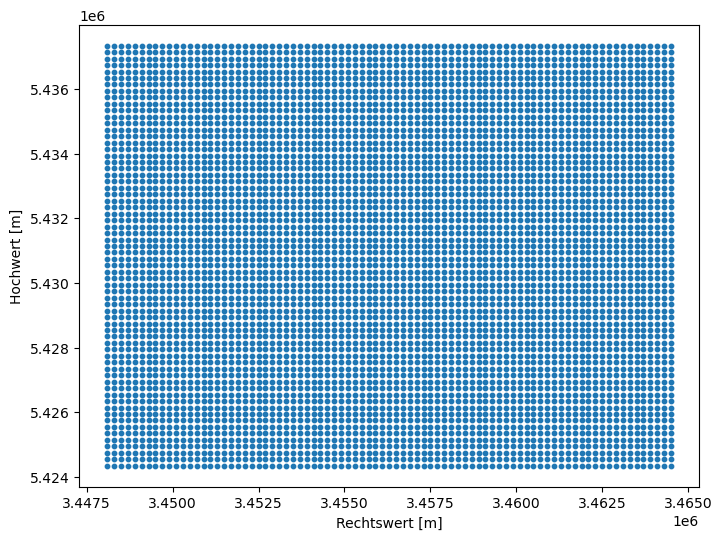

In [11]:
# [1]
# benötigte Packages laden
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Daten aus csv Datei einlesen 
data = pd.read_csv('interp_data.csv', sep=';', encoding='cp1252')

# Ausdehnung des Bereichs inklusive Puffer definieren und zusammenfassen
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]

# grid erzeugen
grid_x, grid_y = np.mgrid[x_min:x_max:200, y_min:y_max:200]

# scatterplot erzeugen
plt.figure(2, figsize=(8,6))
plt.scatter(grid_x, grid_y, s=10)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()

Als nächstes wollen wir die Temperaturdaten mit Hilfe der Funktion `scipy.interpolate.griddata()` interpolieren. 

Als Inputs werden dafür zum Einen die Koordinaten der ursprünglichen Messpunkte als sog. Tuple benötigt. Schreibt dafür die jeweils zusammengehörigen x- und y-Koordinaten in einen gemeinsamen Array (Index [[]]). Um die reinen Zahlenwerte aus einem DataFrame zu extrahieren kann man die Funktion `.values` benutzen, also als `data[[Wert1, Wert2]].values`. 

Die Interpolationsfunktion `scipy.interpolate.griddata()` benötigt neben diesen Tupeln noch die zu interpolierenden Werte (`data.Parameter.values`) und das Grid (d.h. die beiden outputs von oben), auf dem interpoliert werden soll, als Inputs. 

`scipy.interpolate.griddata()` unterstützt verschiedene Interpolationsfunktionen, die über den Input "method=..." spezifizert werden können: "nearest" für Nearest Neighbour, "linear" für eine einfache lineare Interpolation, und "cubic" für eine kubische Spline-Interpolation.  

Definiert drei mit diesen Methoden interpolierte Datensätze und plottet die Ergebnisse zum Vergleich nebeneinander. Zum Plotten von Rasterdaten eignet sich die Funktion `matplotlib.pyplot.imshow()`, die als Inputs das darzustellende Raster (mit `raster.T` transponiert), den Ausgangspunkt (`origin='lower'`) und die Randkoordinaten des Rasters (`extent=area`) benötigt. Als Randkoordinaten könnt ihr hier die im vorherigen Schritt als Koordinaten für die Ausdehnung des Bereichs definierte Variable nutzen. 

Wie gefallen Euch die Ergebnisse der Interpolation?


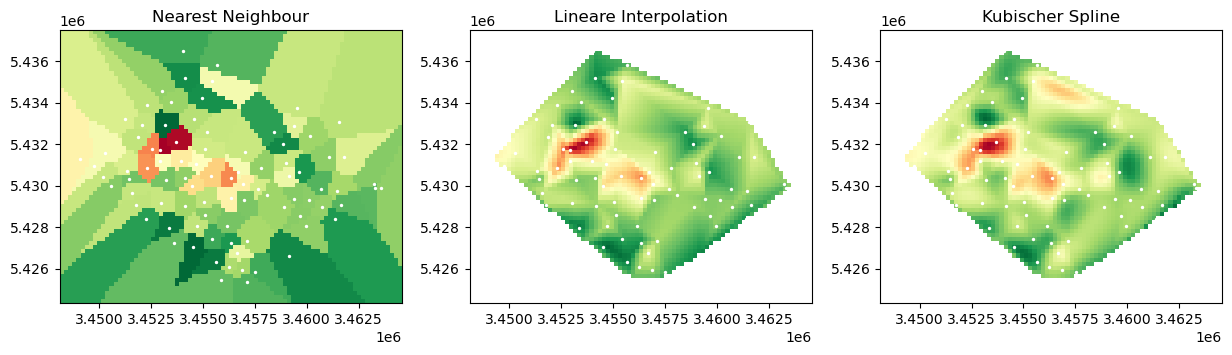

In [12]:
# [2]
# benötigte Packages laden
from scipy.interpolate import griddata

# ursprüngliche Koordinaten in Array mit Tupeln umwandeln
points = data[['Rechtswert', 'Hochwert']].values

# mit griddata drei interpolierte Datensätze erzeugen
grid_z0 = griddata(points, data.GWT.values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, data.GWT.values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, data.GWT.values, (grid_x, grid_y), method='cubic')

#  Abbildung mit 3 subplots definieren
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Nearest Neighbour')

ax = axs[1]
ax.imshow(grid_z1.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Lineare Interpolation')

ax = axs[2]
ax.imshow(grid_z2.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Kubischer Spline')

plt.show()

#### Aufgabe 2: scipy.interpolate.rbf

Neben den Interpolationsmethoden oben, gibt es in `scipy` auch verschiedenen Möglichkeiten zur Interpolation mit Radialen Basisfunktionen (RBFs). Die default-Einstellung von `scipy.interpolate.Rbf()` ist dabei eine Multi-quadratische Funktion, die exakt durch die Stützpunkte geht (exakte Interpolation). 

Definiert nun in dem nächsten Skript zuerst ein Interpolationsobjekt mit Hilfe von `scipy.interpolate.Rbf()`, mit den x- und y-Koordinaten Eurer Messpunkte, sowie den Messwerten als Inputs (`(x-Werte, y-Werte, Messwerte)`). 

Wendet dieses Interpolationsobjekt dann auf die x- und y-Koordinaten des Grids von oben an (`object(x-grid, y-grid)`), und visualisiert anschließend die Ergebnisse. 

Zum visuellen Vergleich der gemessenen und interpolierten Werte könnt ihr euch in der gleichen Abbildung auch die Messwerte darstellen lassen (als Scatterplot mit den Messwerten als Farbe der Punkte,`c=data.Messwerte`). 

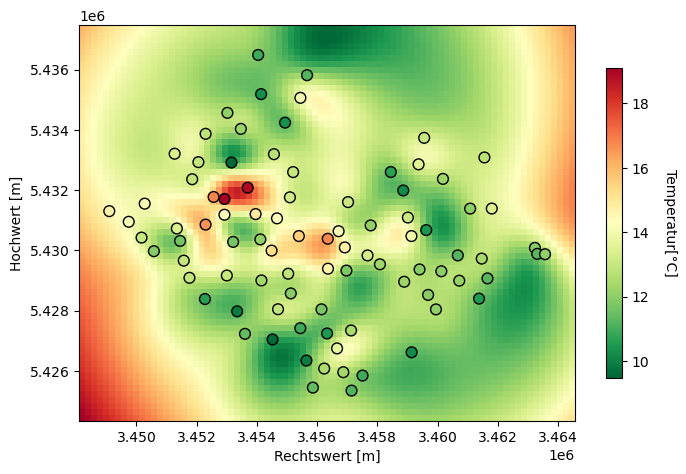

In [13]:
# [3]
# benötigte Packages laden
from scipy.interpolate import Rbf

# Interpolationsobjekt erstellen
rbfi = Rbf(data.Rechtswert, data.Hochwert, data.GWT)

# Interpolationsobjekt anwenden 
di = rbfi(grid_x, grid_y)

# Abbildung mit imshow und scatter erstellen 
plt.figure(3, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

c1 = plt.imshow(di.T, origin="lower", extent=extent, cmap = 'RdYlGn_r')
c2 = plt.scatter(data.Rechtswert, data.Hochwert, s=60, c=data.GWT, edgecolor='k',  cmap = 'RdYlGn_r')

cbar = plt.colorbar(c1, shrink=0.67)
cbar.set_label(label="Temperatur[°C]", rotation=270, labelpad=20)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()


Da die gemessenen Grundwassertemperaturen sicherlich mit gewissen Messfehlern behaftet sind, ist eine exakte Interpolation der Werte nicht unbedingt sinvoll. Mit der Angabe des Arguments `smooth=...` und einem beliebigen Werten > 0 in der Funktion `scipy.interpolate.Rbf()` geht die Interpolation nicht mehr exakt durch die Messpunkte. Damit könnt Ihr das erzeugte Bild der Grundwassertemperaturen etwas glätten.

Ergänzt eurer Skript von von oben mit dem entsprechenden Argument, und probiert verschiedenene Werte für `smooth=...` aus. 

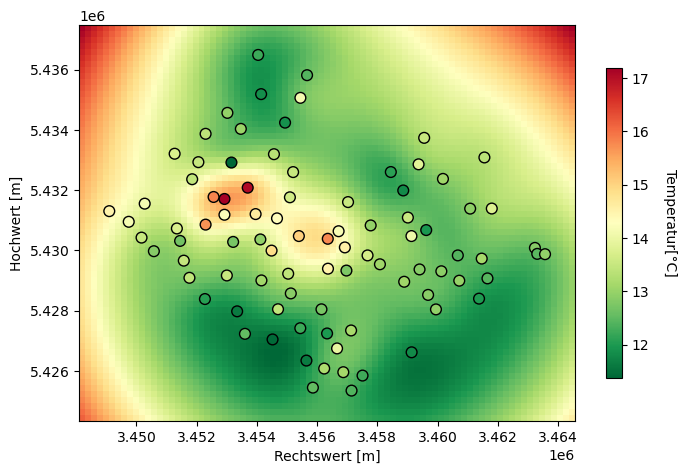

In [14]:
# [4] 
# wie [3] mit ergänztem Attribut in Interpolation
rbfi = Rbf(data.Rechtswert, data.Hochwert, data.GWT, smooth=0.2)
di = rbfi(grid_x, grid_y)

plt.figure(3, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

c1 = plt.imshow(di.T, origin="lower", extent=extent, cmap = 'RdYlGn_r')
c2 = plt.scatter(data.Rechtswert, data.Hochwert, s=60, c=data.GWT, edgecolor='k',  cmap = 'RdYlGn_r')

cbar = plt.colorbar(c1, shrink=0.67)
cbar.set_label(label="Temperatur[°C]", rotation=270, labelpad=20)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()

### Übung 2: Stochastische Interpolationsverfahren - Kriging

 Folgende Python Packages, bzw. Libraries enthalten verschiedene, nützliche Funktionen für die Interpolation von räumlichen Daten mit Hilfe von Kriging: 
 
 - SciKit GStat: bietet detaillierte Möglichkeiten zur Analyse der Variogramme mit verschiedenen Modellen, allerdings nur für Ordinary Kriging (d. h. Daten ohne Trend oder drift) https://scikit-gstat.readthedocs.io/en/latest/install.html#conda-forge
 
 - PyKrige: beinhaltete eine Implementierung von Ordinary und Universal Kriging (für Daten mit Trend/Drift), dafür aber weniger Funktionalität für eine detaillierte Variogrammanalyse https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html

 
In dieser Übung schauen wir uns die Funktionen in SciKit GStat genauer an. Installiert dafür das Package in Euer GDA Environment über den Befehl: `conda install -c conda-forge scikit-gstat`

Erstellt zunächst mit `skgstat.Variogram()` eine Visualisierung der Semivarianz. 

Erzeugt dafür ein Variogram-Objekt mit der Funktion `skgstat.Variogram()`. Als Inputs werden die Koordinaten der Daten als Array mit der Dimension (m, n), sowie die Messwerte benötigt. Hinweis: mit `DataFrame[...].values` und den entsprechenden Indizes in der eckigen Klammer könnt Ihr die Werte als Arrays aus dem Datensatz extrahieren. 

Die graphische Darstellung erfolgt mit `VariogramObjekt.plot()` (Hinweis: setzt an das Ende dieser Zeile ein ";"). 

Je nach Rechenleistung Eures PCs kann die Ausführung einen Augenblick dauern. 

C:\Users\Kathrin_Menberg\AppData\Roaming\Python\Python311\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


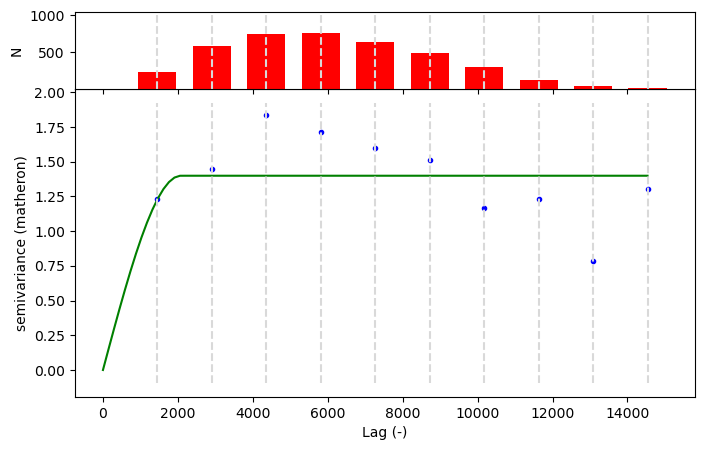

In [20]:
# [5]
# benötigte Packages einladen
from skgstat import Variogram

# Variogrammobjekt erzeugen
Var = Variogram(data[['Rechtswert', 'Hochwert']].values, data.GWT)

# Variogrammobjekt plotten
Var.plot();

Am Histogram ist nun zu erkennen, dass Werte im Bereich von Lags über 8.000 nicht gut durch die Daten unterstützt werden. Daher sollten wir die Größe der berücksichtigten Lags entsprechend reduzieren: `V-Objekt.maxlag = 8000`. 

Da wir über 90 Messwerte haben können wir außerdem die Anzahl der Lag-Klassen etwas erhöhen: `V-Objekt.n_lags=15`. 

Lasst Euch anschließend das veränderte Variogram anzeigen und vergleicht es mit dem von oben. 

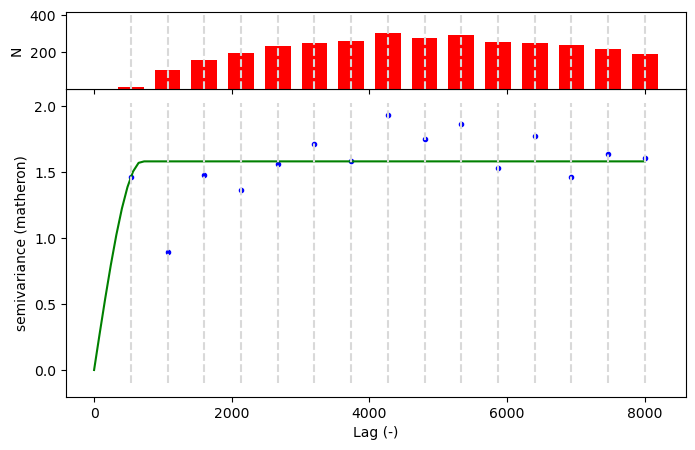

In [16]:
# [7]
# maxlag und nlag des Variogrammobjekts anpassen
Var.maxlag = 8000
Var.n_lags = 15

# Variogrammobjekt plotten
Var.plot(show=False);

Diese Anpassung sieht nun allerdings besonders im Bereich der kurzen Distanzen (niedriege Lags) visuell nicht sehr überzeugend aus. Gerade dieser Bereich ist jedoch wichtig für die Bestimmung der Gewichte für das Kriging. 

Wenn nicht anders definiert nimmt `skgstat.Variogram()` ein sphärisches Varianzmodell an. Erstellt neben diesem noch zwei weitere Variogrammobjekte mit anderen Modellen ("exponential" und "gaussian") über die Angabe von `V-Objekt.model ='name'` (die anderen Angaben zu den Modellen von oben bleiben davon unbeeinflusst). 

Die Variogram-Klasse hat außerdem eine eingebaute Funktionalität um den RMSE (`rmse`) der Anpassung zu berechnen: `V-Objekt.rmse`. Lasst Euch damit die Fehler der Anpassungen ausgeben.

Plottet die verschiedenen Anpassungen zum Vergleich nebeneinander (`matplotlib.subplots()`) und vergleicht den visuellen Eindruck der Anpassung mit den berechneten RMSE-Werten. 

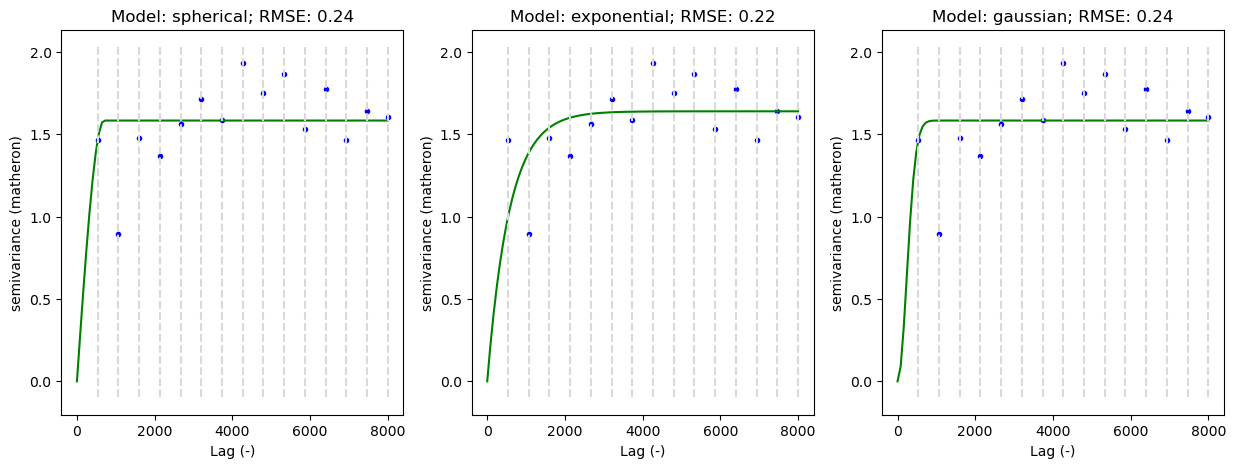

In [17]:
# [8]
# benötigte Packages einladen 
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
Var.model = 'spherical'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('spherical', Var.rmse))

ax = axs[1]
Var.model = 'exponential'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('exponential', Var.rmse))

ax = axs[2]
Var.model = 'gaussian'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('gaussian', Var.rmse))
plt.show()

Wählt nun das passenste Variogramm-Modell aus und führt ein Ordinary Kriging (`skgstat.OrdinaryKriging()`) durch. Dafür sind folgende Schritte nötig: 

- für das Variogramm-Objekt von oben das gewünschte Modell angeben (`V-Objekt.model ='name'`). 

- Interpolationsobjekt definieren: `OrdinaryKriging(Variogramm, min_points=2, max_points=8)`. Die Auswahl der minimal und maximal berücksichtigten Anzahl an Nachbarpunkten orientiert sich an Anzahl und Abstand zwischen den Messpunkten (eine Art Optimierungsparameter)

- gleichmäßiges Grid mit den zu interpolierenden Koordinaten erstellen (siehe letzte Übung)

- Die `.transform()` Funktion auf das Interpolationsobjekt anwenden: Die x- und y-Koordinaten werden dabei als einzelne 1D Numpy Arrays benötigt. Erzeugen könnt Ihr diese z.B. über `array.flatten()` 

- Ergebnis mit `plt.imshow()` visualisieren. Dafür müsst Ihr den eben erzeugten 1-DArray mit den interpolierten Werten wieder umstruktieren, d.h. in seine ursprüngliche Form bringen, z.B. mit `array.reshape(dimensions)`

- plottet auch die Lage der Messpunkte zu dem interpolierten Raster (siehe letzte Übung).

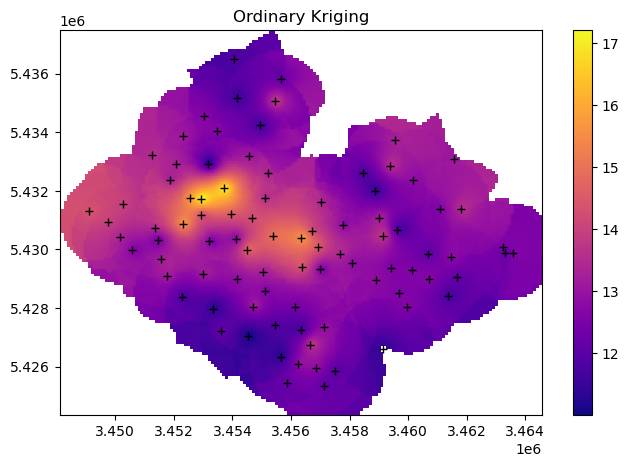

In [18]:
# [9]
# benötigte Packages einladen
from skgstat import OrdinaryKriging
import numpy as np

# Variogramm-Model für das Variogrammobjekt von oben angeben
Var.model = 'exponential'

# Interpolationsobjekt erzeugen
ok = OrdinaryKriging(Var, min_points=2, max_points=8)

# Grid für die Interpolation erstellen
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]
grid_x, grid_y = np.mgrid[x_min:x_max:100, y_min:y_max:100]

# 1D Arrays daraus erzeugen und transform anwenden
field = ok.transform(grid_x.flatten(), grid_y.flatten())

# die mit transform erzeugte Variable auf 2D umstrukturieren 
field = field.reshape(grid_x.shape)

# Abbildung mit imshow erstellen
plt.figure(figsize=(8, 5))
plt.imshow(field.T, origin='lower', extent=extent, cmap='plasma')
plt.title('Ordinary Kriging')
plt.plot(data.Rechtswert, data.Hochwert, '+k')
plt.colorbar()
plt.show()

## Ende

### Referenzen

Menberg et al. (2013): Long-term evolution of anthropogenic heat fluxes into a subsurface urban heat island, Environ. Sci. Technol. 47(17) (2013) 9747-9755

https://colab.research.google.com/github/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb

https://mmaelicke.github.io/scikit-gstat/tutorials/01_getting_started.html